In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/My Drive/02456 Deep learning/Final project/')
# os.getcwd()

Mounted at /content/drive


'/content/drive/My Drive/02456 Deep learning/Final project'

In [1]:
## Imports

%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

In [11]:
## Set up

# Paths
data_path_arrays = 'carseg_data/arrays'

# Class label map color (assume class labels have been mapped to 0-9)
class_to_color = {
    0: (255, 255, 255),  # White (Background)
    1: (255, 165, 0),  # Orange (Hood)
    2: (0, 128, 0),    # Dark Green (Front door)
    3: (255, 255, 0),  # Yellow (Rear door)
    4: (0, 255, 255),  # Cyan (Frame)
    5: (128, 0, 128),  # Purple (Rear quarter panel)
    6: (144, 238, 144),  # Light Green (Trunk lid)
    7: (0, 0, 255),    # Blue (Fender)
    8: (255, 192, 203),  # Pink (Bumper)
    9: (0, 0, 0)      # Black (Rest of the car)
}

In [106]:
## Utlilities

def plot_image(image):
    # Plots a single image on rgb 0-255 scale
    if torch.is_tensor(image):
        image = image.detach().cpu().permute((1, 2, 0)).numpy()
    with sns.axes_style("white"):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()


def segment_image(image, labels):
    # Segments an image based on class labels using color map
    # Returns segmented image as tensor
    if torch.is_tensor(image):
        # Convert tensor to numpy arrays
        image = image.detach().cpu().permute(1, 2, 0).numpy()
        labels = labels.detach().cpu().numpy()
    
    segmented_image = np.zeros_like(image)

    # Color the pixels based on the class values
    # Excluding class 0 and class 90 if want to include background and rest of the car
    for class_value, color in class_to_color.items():
        #if class_value != 0 and class_value != 90:
        segmented_image[labels == class_value] = color

    # If want to include background and rest of the car 
    # segmented_image[label == 0] = image[label == 0]
    # segmented_image[label == 90] = image[label == 90]

    # Convert to tensor
    segmented_image = torch.from_numpy(segmented_image).permute(2, 0, 1).long()

    return segmented_image

def plot_grid_segmented_images(images, labels):
    # Plots a grid of segmented images (tensors)
    segmented_images = []
    for image, label in zip(images, labels):
        segmented_image = segment_image(image, label)
        segmented_images.append(segmented_image)

    plot_image(torchvision.utils.make_grid(segmented_images, nrow=4))

In [70]:
## Segmented image data

test_idx = np.arange(1,31)
test_ids = [f"photo_00{i:02d}.npy" for i in test_idx]

class SegmentedImageDataset(TensorDataset):
    def __init__(self, data_folder_arrays, train, transform=None):
        self.data_folder = data_folder_arrays
        self.data_files = os.listdir(data_folder_arrays)
        self.train = train
        self.transform = transform
        if self.train:
            # Exclude the test filenames to create the training dataset
            self.data_files = [file for file in self.data_files if file not in test_ids]
        else:
            # Include only the test filenames for the test dataset
            self.data_files = [file for file in self.data_files if file in test_ids]

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        file_name = os.path.join(self.data_folder, self.data_files[idx])
        image_data = np.load(file_name)
        image = image_data[:,:,:3]
        image = (image - np.min(image)) / (np.max(image) - np.min(image))   # min-max normalization for the image
        class_labels = image_data[:,:,3]/10   # map class labels to 0-9
        if self.transform:
            image = self.transform(image)
        return torch.from_numpy(image).permute(2, 0, 1).float(), torch.tensor(class_labels).long()

# TODO: normalize (or standardize?) data (er núna að gera min-max normalization en veit ekki
# hvort það sé rétt því þetta er alltaf min og max fyrir sérhverja mynd en ekki allar myndirnar)
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
#     ]
# )

batch_size = 8
num_workers = 0

train_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=True)
test_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Training data:


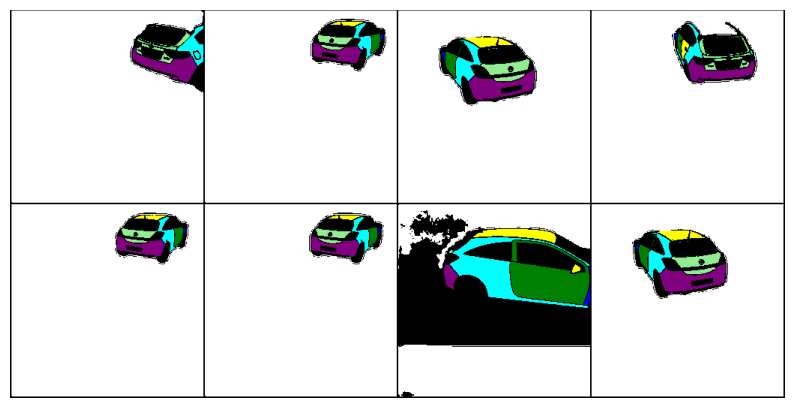

Testing data:


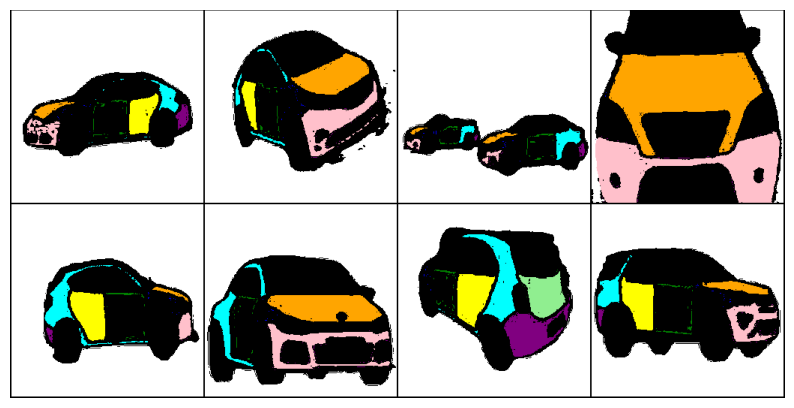

In [71]:
## Visulize image data

print('Training data:')
images_train, labels_train = next(iter(train_dataloader))
plot_grid_segmented_images(images_train, labels_train)

print('Testing data:')
images_test, labels_test = next(iter(test_dataloader))
plot_grid_segmented_images(images_test, labels_test)

In [ ]:
## More preprocessing? TODO

# Grayscale instead of colors?

In [86]:
## Model

import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expanding path
        self.up1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128 + 64, 64)
        self.up2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64 + 32, 32)

        self.out = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.enc1(x)
        p1 = self.pool(c1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)

        c3 = self.enc3(p2)

        # Expanding path
        up1 = self.up1(c3)
        merge1 = torch.cat([up1, c2], dim=1)
        d1 = self.dec1(merge1)

        up2 = self.up2(d1)
        merge2 = torch.cat([up2, c1], dim=1)
        d2 = self.dec2(merge2)

        out = self.out(d2)
        return out

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )


model = UNet(in_channels=3, out_channels=10)
print(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up1): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec1): Sequential(
    (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d

In [87]:
## Model configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=10).to(device)
criterion = nn.CrossEntropyLoss()   # TODO: look at more loss functions (e.g. IoU loss)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [88]:
## Training loop

# TODO: techically this is not validation loss but test loss so we could also create validation set maybe
# TODO: choose appropriate metric to evaluate model

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_training_loss = 0.0

    # Wrap dataloader with tqdm for a loading bar
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_training_loss += loss.item() * images.size(0)   # multiply with size of batch since final batch of the dataloader might be smaller

    # Valdiation loss
    running_validation_loss = 0.0
    with torch.no_grad():
        model.eval()
        for images, masks in test_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_validation_loss += loss.item() * images.size(0)

    epoch_training_loss = running_training_loss / len(train_dataloader.dataset)
    epoch_validation_loss = running_validation_loss / len(test_dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {epoch_training_loss:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {epoch_validation_loss:.4f}")


Epoch 1/5:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch [1/5] Training Loss: 0.5060
Epoch [1/5] Validation Loss: 1.1347


Epoch 2/5:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch [2/5] Training Loss: 0.3759
Epoch [2/5] Validation Loss: 1.0958


Epoch 3/5:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch [3/5] Training Loss: 0.3042
Epoch [3/5] Validation Loss: 1.0785


Epoch 4/5:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch [4/5] Training Loss: 0.2630
Epoch [4/5] Validation Loss: 0.9667


Epoch 5/5:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch [5/5] Training Loss: 0.2388
Epoch [5/5] Validation Loss: 0.9238


In [94]:
## Save and load model

path_to_model = 'model_v1'
#torch.save(model, path_to_model)
model = torch.load(path_to_model)
model.eval();

Test:


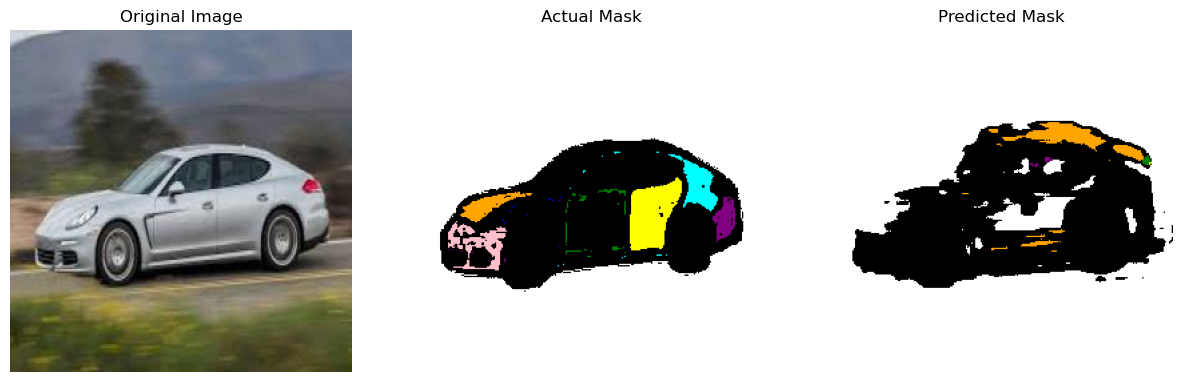

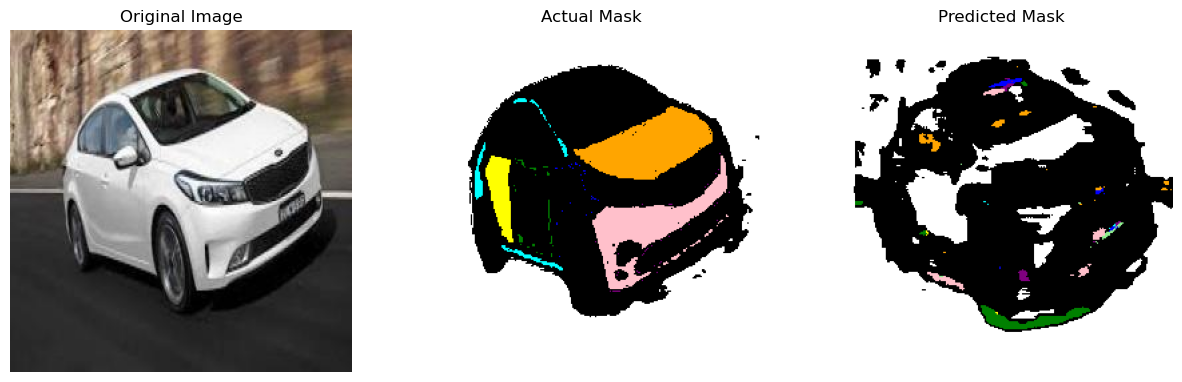

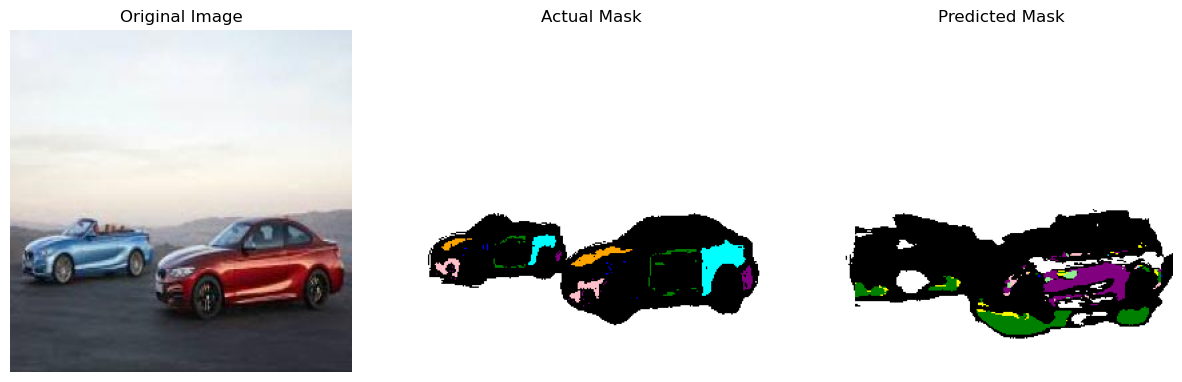

Train:


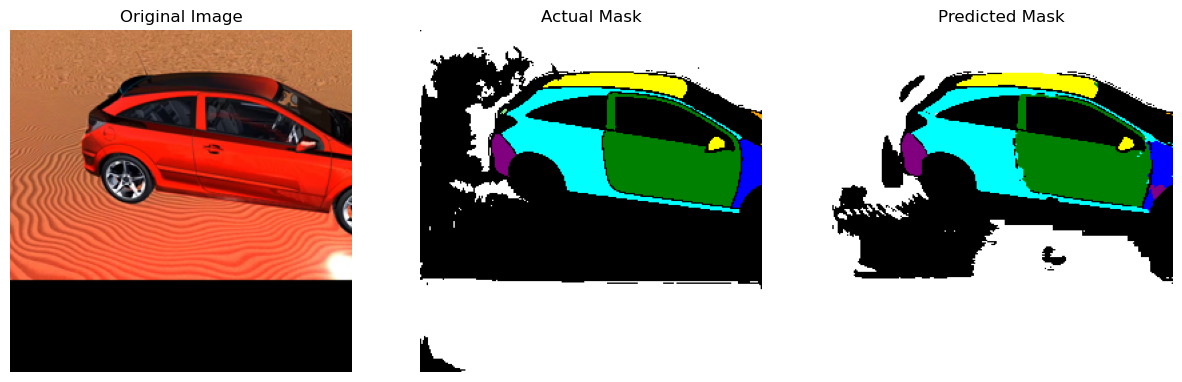

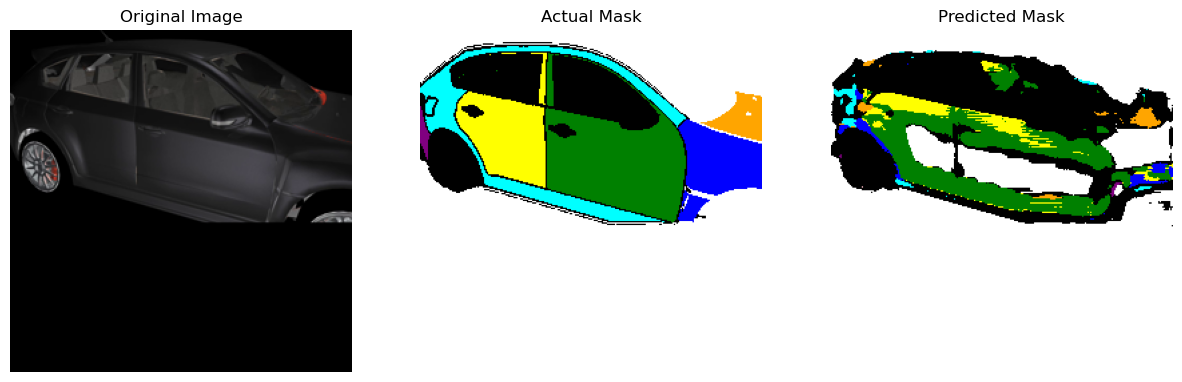

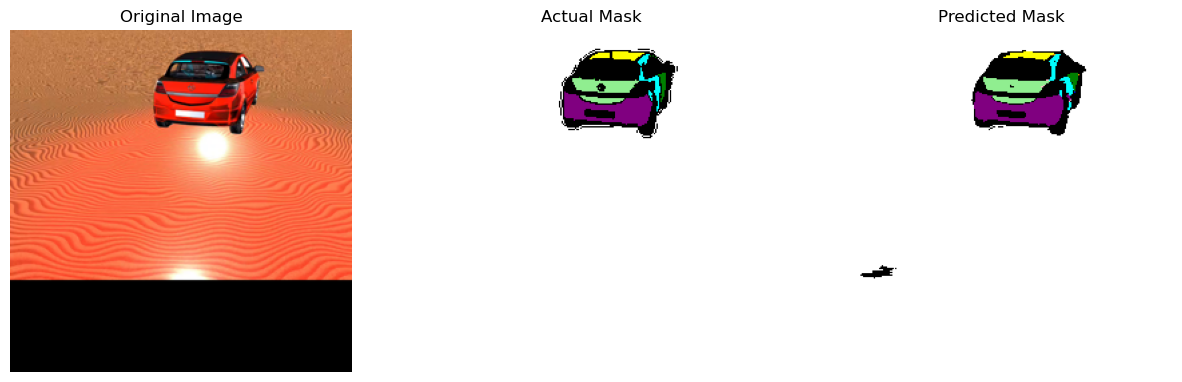

In [125]:
## Visualize results

def visualize_results(images, masks, num_examples):
    # Compares visually 'num_examples' of images with the actual and predicted mask

    # Predict masks with the model
    model.eval()
    with torch.no_grad():
        preds = model(images)

    # Take the argmax to get the class label for each pixel
    pred_masks = preds.argmax(dim=1)

    for i in range(num_examples if num_examples < batch_size else batch_size):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        # Original image
        img = images[i].detach().cpu().permute((1, 2, 0)).numpy().astype(int)
        ax1.imshow(img)
        ax1.set_title('Original Image')
        ax1.axis('off')

        # Actual mask
        true_mask = segment_image(images[i], masks[i]).permute((1, 2, 0)).long()
        ax2.imshow(true_mask)
        ax2.set_title('Actual Mask')
        ax2.axis('off')

        # Predicted mask
        pred_mask = segment_image(images[i], pred_masks[i]).permute((1, 2, 0)).long()
        ax3.imshow(pred_mask)
        ax3.set_title('Predicted Mask')
        ax3.axis('off')

        plt.show()


# Get a batch of images and masks from the dataloader
print('Test:')
images, masks = next(iter(test_dataloader))
images, masks = images.to(device), masks.to(device)
visualize_results(images, masks, num_examples=3)

print('Train:')
images, masks = next(iter(train_dataloader))
images, masks = images.to(device), masks.to(device)
visualize_results(images, masks, num_examples=3)

In [ ]:
# https://towardsdatascience.com/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923

In [ ]:
# NB for model metric we use:
#    Dice score can be used to evaluate the similarity between a predicted segmentation mask and the
#    ground truth segmentation mask

# Þannig að þetta er hlutfall af segment-i sem er classify-að rétt, ekki að módelið
# geti sagt okkur hvort þessi partur sé hurð eða ekki...

In [ ]:
# https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [ ]:
# We want to classify each pixel as one of the classes - what about class 0 (which I think is background)?
# Should that be part of e.g. the classification metric?

In [ ]:
#from torchmetrics.functional import dice_score

def dice_score(predicted, target):
    pass

# TODO